In [1]:
#RFE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv('Data/train.csv')

In [3]:
train.head()

,price,wheelbase,curbweight,enginesize,boreratio,horsepower,carlength,carwidth,gas,turbo,...,ohcv,rotor,five,four,six,three,twelve,two,Medium,Highend
0,18344,104.9,2700,134,3.43,72,175.0,66.1,False,False,...,False,False,False,True,False,False,False,False,True,False
1,15580,107.9,3075,120,3.46,95,186.7,68.4,True,False,...,False,False,False,True,False,False,False,False,True,False
2,6918,95.7,2280,92,3.05,62,169.7,63.6,True,False,...,False,False,False,True,False,False,False,False,False,False
3,7499,94.5,1971,97,3.15,69,165.3,63.8,True,False,...,False,False,False,True,False,False,False,False,True,False
4,9095,96.5,2289,110,3.15,86,167.5,65.2,True,False,...,False,False,False,True,False,False,False,False,False,False


In [4]:
scaler = MinMaxScaler()
num_vars = ['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower','carlength','carwidth','price']
train[num_vars] = scaler.fit_transform(train[num_vars])

In [5]:
columns = list(train.columns)
for column in columns[8:]:
    train[column] = train[column].astype(int)

In [6]:
y_train = train.pop('price')
X_train = train

In [7]:
print(X_train.shape)
print(y_train.shape)

(164, 29)
(164,)


In [8]:
lm = LinearRegression()

In [9]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train,y_train)

In [10]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('wheelbase', False, 12),
 ('curbweight', True, 1),
 ('enginesize', False, 5),
 ('boreratio', True, 1),
 ('horsepower', True, 1),
 ('carlength', False, 8),
 ('carwidth', True, 1),
 ('gas', False, 13),
 ('turbo', False, 19),
 ('hardtop', False, 14),
 ('hatchback', True, 1),
 ('sedan', True, 1),
 ('wagon', True, 1),
 ('fwd', False, 18),
 ('rwd', False, 17),
 ('dohcv', True, 1),
 ('l', False, 16),
 ('ohc', False, 15),
 ('ohcf', False, 7),
 ('ohcv', False, 6),
 ('rotor', False, 9),
 ('five', False, 4),
 ('four', False, 2),
 ('six', False, 3),
 ('three', False, 20),
 ('twelve', True, 1),
 ('two', False, 11),
 ('Medium', False, 10),
 ('Highend', True, 1)]

In [11]:
#Selects the top 10 columns from the dataframe
X_train.columns[rfe.support_]

Index(['curbweight', 'boreratio', 'horsepower', 'carwidth', 'hatchback',
       'sedan', 'wagon', 'dohcv', 'twelve', 'Highend'],
      dtype='object')

#### Building the models
Using statsmodels for detailed statistics

In [12]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]

In [13]:
X_train_rfe.head()

,curbweight,boreratio,horsepower,carwidth,hatchback,sedan,wagon,dohcv,twelve,Highend
0,0.392078,0.635714,0.084746,0.409524,0,1,0,0,0,0
1,0.558968,0.657143,0.182203,0.628571,0,1,0,0,0,0
2,0.205162,0.364286,0.042373,0.171429,0,0,1,0,0,0
3,0.067646,0.435714,0.072034,0.190476,0,1,0,0,0,0
4,0.209168,0.435714,0.144068,0.323810,1,0,0,0,0,0


In [14]:
def build_model(X,y):
    '''
    The below command is used to add an intercept to the equation i.e. y = mx + b. This is done because the model by default
    assumes the value of b to be 0 if not given explicitly. This causes the algorithm to not optimise b at all, which is 
    undesirable.
    '''
    X = sm.add_constant(X)
    lm = sm.OLS(y,X).fit() #fitting the model 
    print(lm.summary()) # model summary
    return X

In [15]:
'''
The variance inflation factor actually checks for the multicollinearity among the independent variables. 
A VIF value under 5 means that the variables are not that correlated. Any value greater than 10 usually means
that the variables are highly correlated. This does not diminish the predictive power of the model but it does make
the prediction unreliable. This is because 'same' data is being added because of the collinearity
'''
def checkVIF(X):
    vif = pd.DataFrame()
    vif['features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF',ascending=False)
    return vif

Model 1

In [16]:
X_train_rfe.shape

(164, 10)

In [17]:
X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     231.1
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           5.86e-87
Time:                        22:32:48   Log-Likelihood:                 266.07
No. Observations:                 164   AIC:                            -510.1
Df Residuals:                     153   BIC:                            -476.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0811      0.023      3.525      0.0

In [19]:
X_train_new = X_train_rfe.drop(["twelve"],axis=1) #High p value

In [20]:
X_train_new.shape

(164, 9)

In [21]:
checkVIF(X_train_new)

,features,VIF
0,curbweight,20.05
3,carwidth,19.30
1,boreratio,10.92
2,horsepower,8.80
5,sedan,4.09
4,hatchback,3.09
6,wagon,1.96
8,Highend,1.81
7,dohcv,1.28


Model 2

In [22]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     252.1
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           2.13e-87
Time:                        22:33:15   Log-Likelihood:                 264.15
No. Observations:                 164   AIC:                            -508.3
Df Residuals:                     154   BIC:                            -477.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0860      0.023      3.734      0.0

In [23]:
checkVIF(X_train_new)

,features,VIF
0,const,35.00
1,curbweight,6.85
6,sedan,5.27
5,hatchback,4.98
4,carwidth,4.09
3,horsepower,3.38
7,wagon,3.10
2,boreratio,1.78
9,Highend,1.62
8,dohcv,1.35


In [24]:
X_train_new = X_train_new.drop(['curbweight'],axis=1)

Curbweight has high VIF so dropping it

Model 3

In [28]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     248.3
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           2.83e-84
Time:                        22:34:24   Log-Likelihood:                 253.49
No. Observations:                 164   AIC:                            -489.0
Df Residuals:                     155   BIC:                            -461.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0616      0.024      2.583      0.0

In [29]:
X_train_new.shape

(164, 9)

In [30]:
checkVIF(X_train_new)

,features,VIF
0,const,33.16
5,sedan,5.26
4,hatchback,4.97
6,wagon,2.93
2,horsepower,2.55
3,carwidth,1.99
1,boreratio,1.67
8,Highend,1.60
7,dohcv,1.19


In [31]:
X_train_new = X_train_new.drop(['sedan'],axis=1)

Dropping 'sedan' because of high VIF value

Model 4

In [32]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     236.0
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           1.39e-79
Time:                        22:38:14   Log-Likelihood:                 239.08
No. Observations:                 164   AIC:                            -462.2
Df Residuals:                     156   BIC:                            -437.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0404      0.016     -2.500      0.0

In [33]:
checkVIF(X_train_new)

,features,VIF
0,const,12.81
2,horsepower,2.39
3,carwidth,1.82
1,boreratio,1.61
7,Highend,1.57
4,hatchback,1.22
6,dohcv,1.17
5,wagon,1.13


In [34]:
#Dropping wagon because of high p value
X_train_new = X_train_new.drop(['wagon'],axis=1)

Model 5

In [35]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     275.5
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           1.19e-80
Time:                        22:40:58   Log-Likelihood:                 238.66
No. Observations:                 164   AIC:                            -463.3
Df Residuals:                     157   BIC:                            -441.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0415      0.016     -2.578      0.0

In [36]:
checkVIF(X_train_new)

,features,VIF
0,const,12.73
2,horsepower,2.39
3,carwidth,1.81
1,boreratio,1.60
6,Highend,1.51
5,dohcv,1.17
4,hatchback,1.13


Model 6

In [37]:
#Dropping boreratio to see the changes in model statistics
X_train_new = X_train_new.drop(["boreratio"], axis = 1)
X_train_new = build_model(X_train_new,y_train)
checkVIF(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     332.5
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           6.46e-82
Time:                        22:45:38   Log-Likelihood:                 238.62
No. Observations:                 164   AIC:                            -465.2
Df Residuals:                     158   BIC:                            -446.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0446      0.011     -3.899      0.0

,features,VIF
0,const,6.49
1,horsepower,2.17
2,carwidth,1.70
5,Highend,1.51
4,dohcv,1.17
3,hatchback,1.11


### Residual Analysis of Model 

In [38]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train_price = lm.predict(X_train_new)

In [47]:
error = y_train-y_train_price

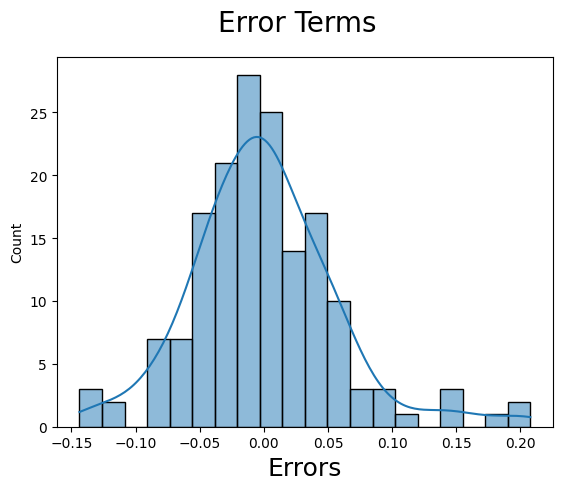

In [48]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.histplot(error, bins = 20, kde=True)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)   
plt.show()

Error terms are normally distributed; The data is fit with the best fit line.

### Prediction and evaluation 